Analyzing Odds Data

In the last notebook, we obtained historical odds data from oddsshark, and then augmented our game level data to include the implied probabilities, and over/under lines.
We saved that data to a file called 'df_bp3.csv'
In this notebook, we will do some initial exploration of that odds data, and compare the quality of our first model predictions to the implied probabilities given by the oddsmakers.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgbm
import structureboost as stb
import ml_insights as mli
from structureboost import log_loss
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)


In [2]:
df=pd.read_csv('df_bp3.csv', low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116079 entries, 0 to 116078
Columns: 199 entries, date to over_under_result
dtypes: float64(108), int64(12), object(79)
memory usage: 176.2+ MB


In [4]:
# checks to see if '0-probability' occurs in correct spots

pd.crosstab(df.implied_prob_h>0, df.season)

season,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
implied_prob_h,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,1944,1938,1859,1943,1945,1934,1939,2103,2102,2099,2105,1394,2107,2109,2105,2103,2103,2105,2100,2106,2105,2104,2106,2269,1600,2017,2267,2266,2432,2428,2429,2429,2426,2430,2428,2431,2429,2431,2428,2430,2430,2429,2430,2431,2430,2429,2428,2430,2431,0,0,0,0
True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2429,898,2426,2430


In [5]:
df_odds = df[df.season>=2019]

In [6]:
df_odds.sample(5)

,date,dblheader_code,day_of_week,team_v,league_v,game_no_v,team_h,league_h,game_no_h,runs_v,runs_h,outs_total,day_night,completion_info,forfeit_info,protest_info,ballpark_id,attendance,game_minutes,linescore_v,linescore_h,AB_v,H_v,2B_v,3B_v,HR_v,RBI_v,SH_v,SF_v,HBP_v,BB_v,IBB_v,SO_v,SB_v,CS_v,GIDP_v,CI_v,LOB_v,P_num_v,ERind_v,ERteam_v,WP_v,balk_v,PO_v,ASST_v,ERR_v,PB_v,DP_v,TP_v,AB_h,H_h,2B_h,3B_h,HR_h,RBI_h,SH_h,SF_h,HBP_h,BB_h,IBB_h,SO_h,SB_h,CS_h,GIDP_h,CI_h,LOB_h,P_num_h,ERind_h,ERteam_h,WP_h,balk_h,PO_h,ASST_h,ERR_h,PB_h,DP_h,TP_h,ump_HB_id,ump_HB_name,ump_1B_id,ump_1B_name,ump_2B_id,ump_2B_name,ump_3B_id,ump_3B_name,ump_LF_id,ump_LF_name,ump_RF_id,ump_RF_name,mgr_id_v,mgr_name_v,mgr_id_h,mgr_name_h,pitcher_id_w,pitcher_name_w,pitcher_id_l,pitcher_name_l,pitcher_id_s,pitcher_name_s,GWRBI_id,GWRBI_name,pitcher_start_id_v,pitcher_start_name_v,pitcher_start_id_h,pitcher_start_name_h,batter1_name_v,batter1_id_v,batter1_pos_v,batter2_name_v,batter2_id_v,batter2_pos_v,batter3_name_v,batter3_id_v,batter3_pos_v,batter4_name_v,batter4_id_v,batter4_pos_v,batter5_name_v,batter5_id_v,batter5_pos_v,batter6_name_v,batter6_id_v,batter6_pos_v,batter7_name_v,batter7_id_v,batter7_pos_v,batter8_name_v,batter8_id_v,batter8_pos_v,batter9_name_v,batter9_id_v,batter9_pos_v,batter1_name_h,batter1_id_h,batter1_pos_h,batter2_name_h,batter2_id_h,batter2_pos_h,batter3_name_h,batter3_id_h,batter3_pos_h,batter4_name_h,batter4_id_h,batter4_pos_h,batter5_name_h,batter5_id_h,batter5_pos_h,batter6_name_h,batter6_id_h,batter6_pos_h,batter7_name_h,batter7_id_h,batter7_pos_h,batter8_name_h,batter8_id_h,batter8_pos_h,batter9_name_h,batter9_id_h,batter9_pos_h,misc_info,acqui_info,season,run_diff,home_victory,run_total,date_dblhead,BATAVG_162_h,BATAVG_162_v,OBP_162_h,OBP_162_v,SLG_162_h,SLG_162_v,OBS_162_h,OBS_162_v,SB_162_h,SB_162_v,CS_162_h,CS_162_v,ERR_162_h,ERR_162_v,BATAVG_30_h,BATAVG_30_v,OBP_30_h,OBP_30_v,SLG_30_h,SLG_30_v,OBS_30_h,OBS_30_v,SB_30_h,SB_30_v,CS_30_h,CS_30_v,ERR_30_h,ERR_30_v,implied_prob_h,implied_prob_v,implied_prob_h_mid,over_under_line,over_under_result
115319,20220811,0,Thu,MIA,NL,111,PHI,NL,111,3,0,54,D,NaN,NaN,NaN,PHI13,25444.0,187.0,010002000,000000000,34.0,7.0,2.0,1.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,8.0,1.0,0.0,1.0,0.0,6.0,4.0,0.0,0.0,0.0,0.0,27.0,8.0,0.0,0.0,0.0,0.0,33.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,13.0,0.0,1.0,0.0,0.0,10.0,4.0,2.0,2.0,1.0,0.0,27.0,5.0,1.0,0.0,1.0,0.0,ortir901,Roberto Ortiz,eddid901,Doug Eddings,knigb901,Brian Knight,willr901,Ryan Wills,NaN,(none),NaN,(none),mattd001,Don Mattingly,giraj001,Joe Girardi,cabre003,Edward Cabrera,gibsk002,Kyle Gibson,scott003,Tanner Scott,wendj002,Joey Wendle,cabre003,Edward Cabrera,gibsk002,Kyle Gibson,wendj002,Joey Wendle,4.0,rojam002,Miguel Rojas,6.0,coopg002,Garrett Cooper,10.0,bledj001,JJ Bleday,9.0,fortn001,Nick Fortes,2.0,leblc001,Charles Leblanc,5.0,diazl001,Lewin Diaz,3.0,burdp001,Peyton Burdick,8.0,willl001,Luke Williams,7.0,schwk001,Kyle Schwarber,7.0,hoskr001,Rhys Hoskins,3.0,bohma001,Alec Bohm,5.0,halld003,Darick Hall,10.0,castn001,Nick Castellanos,9.0,stotb001,Bryson Stott,6.0,seguj002,Jean Segura,4.0,stubg001,Garrett Stubbs,2.0,vierm001,Matt Vierling,8.0,NaN,Y,2022,-3,0,3,202208110,0.244449,0.232831,0.308067,0.289433,0.419527,0.369998,0.727594,0.659431,82.0,115.0,18.0,28.0,73.0,96.0,0.255489,0.214431,0.300188,0.260287,0.442116,0.302846,0.742303,0.563133,15.0,25.0,4.0,7.0,7.0,15.0,0.607843,0.416667,0.595588,8.0,U
114532,20220611,0,Sat,BAL,AL,60,KCA,AL,58,6,4,54,D,NaN,NaN,NaN,KAN06,15134.0,183.0,000013110,100200010,35.0,10.0,2.0,0.0,1.0,5.0,0.0,0.0,0.0,3.0,0.0,11.0,1.0,1.0,0.0,0.0,5.0,5.0,4.0,4.0,0.0,0.0,27.0,10.0,0.0,0.0,1.0,0.0,35.0,10.0,1.0,1.0,0.0,4.0,0.0,1.0,0.0,2.0,0.0,5.0,0.0,0.0,1.0,0.0,7.0,4.0,6.0,6.0,1.0,0.0,27.0,8.0,1.0,0.0,0.0,0.0,vondc901,Clint Vondrak,iassd901,Dan Iassogna,barrs901,Scott Barry,may-b901,Ben May,NaN,(none),NaN,(none),hydeb801,Brandon Hyde,mathm001,Mike Matheny,wellt003,Tyler Wells,lyncd001,Daniel Lynch,lopej004,Jorge Lopez,nevit001,Tyle

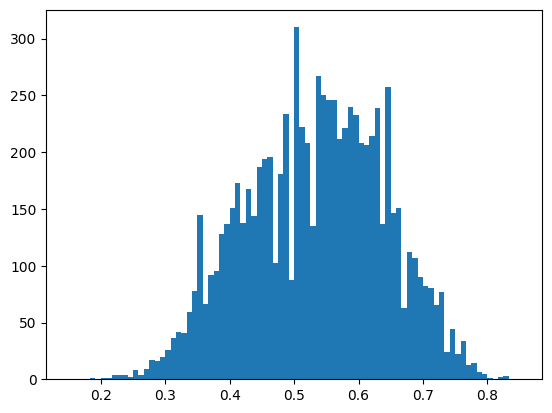

In [7]:
plt.hist(df_odds.implied_prob_h_mid, bins=np.linspace(.15,.85,85));

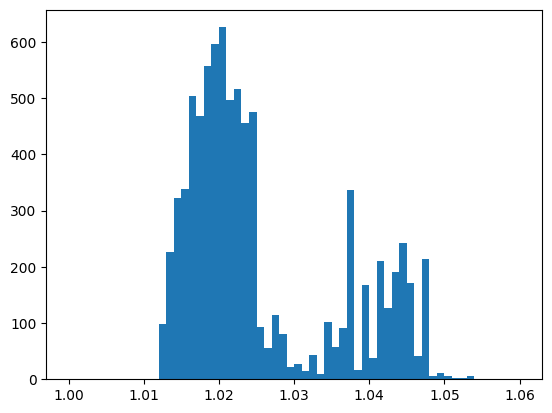

In [8]:
plt.hist(df_odds.implied_prob_h + df_odds.implied_prob_v, bins=np.linspace(1,1.06,61));

# interesting to see second peak around 1.04-1.05 ... IDEAS??

In [9]:
df = df[df.run_diff!=0]
df_train = df[(df.season>1901) & (df.season<=2000)]
df_valid = df[(df.season>=2001) & (df.season<=2020)]
df_test = df[df.season>=2021]

In [10]:
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            # 'OBP_30_h','OBP_30_v',
            # 'SLG_30_h','SLG_30_v',
            # 'game_no_h',
           ]
target = 'home_victory'

In [11]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()
X_train.shape, X_valid.shape, X_test.shape, 

((64123, 4), (47052, 4), (4856, 4))

In [12]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=3)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.689183
[20]	valid_0's binary_logloss: 0.68852
[30]	valid_0's binary_logloss: 0.688011
[40]	valid_0's binary_logloss: 0.687647
[50]	valid_0's binary_logloss: 0.687281
[60]	valid_0's binary_logloss: 0.687068
[70]	valid_0's binary_logloss: 0.686829
[80]	valid_0's binary_logloss: 0.686659
[90]	valid_0's binary_logloss: 0.686498
[100]	valid_0's binary_logloss: 0.686365
[110]	valid_0's binary_logloss: 0.686257
[120]	valid_0's binary_logloss: 0.686208
[130]	valid_0's binary_logloss: 0.686157
[140]	valid_0's binary_logloss: 0.686121
[150]	valid_0's binary_logloss: 0.686106
[160]	valid_0's binary_logloss: 0.686093
[170]	valid_0's binary_logloss: 0.68609
[180]	valid_0's binary_logloss: 0.686075
[190]	valid_0's binary_logloss: 0.686096
[200]	valid_0's binary_logloss: 0.686125
[210]	valid_0's binary_logloss: 0.686137
[220]	valid_0's binary_logloss: 0.686162
[230]	valid_0's binary_logloss: 0.686183
Early s

LGBMClassifier(learning_rate=0.02, max_depth=3, n_estimators=1000)

In [13]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [14]:
hv_mean = y_train.mean()

In [15]:
lgbm_loss = log_loss(y_test, preds_lgbm)
naive_loss = log_loss(y_test, hv_mean*np.ones(len(y_test)))
lgbm_loss, naive_loss

(0.6851304948462116, 0.6904931735041051)

In [16]:
lv_loss = log_loss(y_test, df_test.implied_prob_h_mid)
lv_loss

0.6674197609198098

In [17]:
(naive_loss - lgbm_loss)/(naive_loss - lv_loss)

0.23241809759617374

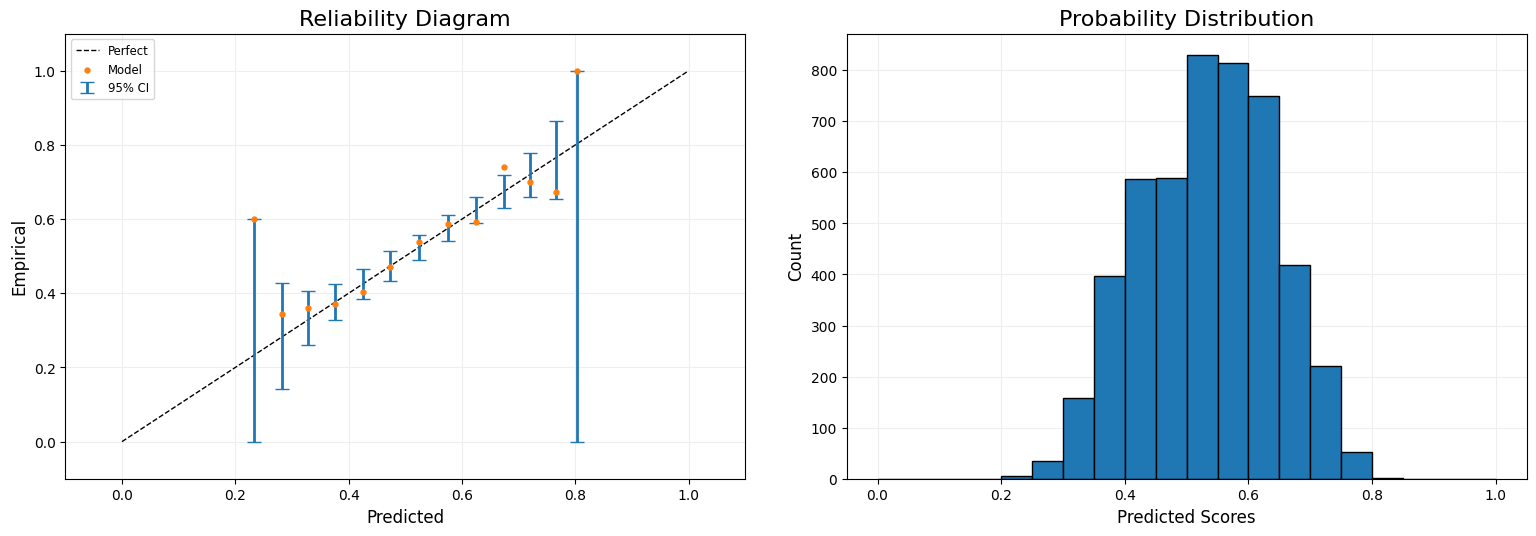

In [18]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, df_test.implied_prob_h_mid, show_histogram=True);

In [19]:
test_disc = np.abs(preds_lgbm - df_test.implied_prob_h_mid)

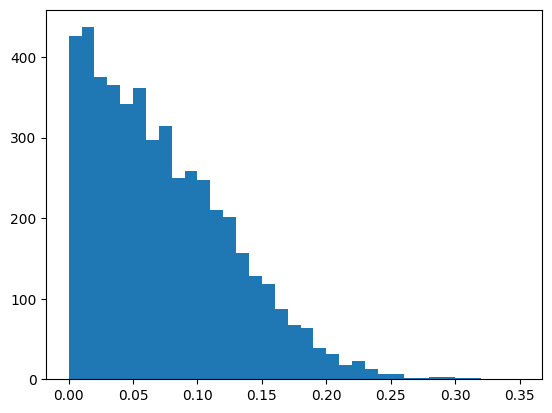

In [20]:
plt.hist(test_disc, np.linspace(0,.35,36));

In [21]:
df_test[test_disc>0.25]

,date,dblheader_code,day_of_week,team_v,league_v,game_no_v,team_h,league_h,game_no_h,runs_v,runs_h,outs_total,day_night,completion_info,forfeit_info,protest_info,ballpark_id,attendance,game_minutes,linescore_v,linescore_h,AB_v,H_v,2B_v,3B_v,HR_v,RBI_v,SH_v,SF_v,HBP_v,BB_v,IBB_v,SO_v,SB_v,CS_v,GIDP_v,CI_v,LOB_v,P_num_v,ERind_v,ERteam_v,WP_v,balk_v,PO_v,ASST_v,ERR_v,PB_v,DP_v,TP_v,AB_h,H_h,2B_h,3B_h,HR_h,RBI_h,SH_h,SF_h,HBP_h,BB_h,IBB_h,SO_h,SB_h,CS_h,GIDP_h,CI_h,LOB_h,P_num_h,ERind_h,ERteam_h,WP_h,balk_h,PO_h,ASST_h,ERR_h,PB_h,DP_h,TP_h,ump_HB_id,ump_HB_name,ump_1B_id,ump_1B_name,ump_2B_id,ump_2B_name,ump_3B_id,ump_3B_name,ump_LF_id,ump_LF_name,ump_RF_id,ump_RF_name,mgr_id_v,mgr_name_v,mgr_id_h,mgr_name_h,pitcher_id_w,pitcher_name_w,pitcher_id_l,pitcher_name_l,pitcher_id_s,pitcher_name_s,GWRBI_id,GWRBI_name,pitcher_start_id_v,pitcher_start_name_v,pitcher_start_id_h,pitcher_start_name_h,batter1_name_v,batter1_id_v,batter1_pos_v,batter2_name_v,batter2_id_v,batter2_pos_v,batter3_name_v,batter3_id_v,batter3_pos_v,batter4_name_v,batter4_id_v,batter4_pos_v,batter5_name_v,batter5_id_v,batter5_pos_v,batter6_name_v,batter6_id_v,batter6_pos_v,batter7_name_v,batter7_id_v,batter7_pos_v,batter8_name_v,batter8_id_v,batter8_pos_v,batter9_name_v,batter9_id_v,batter9_pos_v,batter1_name_h,batter1_id_h,batter1_pos_h,batter2_name_h,batter2_id_h,batter2_pos_h,batter3_name_h,batter3_id_h,batter3_pos_h,batter4_name_h,batter4_id_h,batter4_pos_h,batter5_name_h,batter5_id_h,batter5_pos_h,batter6_name_h,batter6_id_h,batter6_pos_h,batter7_name_h,batter7_id_h,batter7_pos_h,batter8_name_h,batter8_id_h,batter8_pos_h,batter9_name_h,batter9_id_h,batter9_pos_h,misc_info,acqui_info,season,run_diff,home_victory,run_total,date_dblhead,BATAVG_162_h,BATAVG_162_v,OBP_162_h,OBP_162_v,SLG_162_h,SLG_162_v,OBS_162_h,OBS_162_v,SB_162_h,SB_162_v,CS_162_h,CS_162_v,ERR_162_h,ERR_162_v,BATAVG_30_h,BATAVG_30_v,OBP_30_h,OBP_30_v,SLG_30_h,SLG_30_v,OBS_30_h,OBS_30_v,SB_30_h,SB_30_v,CS_30_h,CS_30_v,ERR_30_h,ERR_30_v,implied_prob_h,implied_prob_v,implied_prob_h_mid,over_under_line,over_under_result
111236,20210402,0,Fri,LAN,NL,2,COL,NL,2,11,6,54,N,NaN,NaN,NaN,DEN02,20363.0,199.0,220310210,000000600,41.0,16.0,5.0,2.0,0.0,11.0,2.0,1.0,1.0,2.0,0.0,7.0,0.0,0.0,0.0,0.0,9.0,3.0,6.0,6.0,0.0,0.0,27.0,7.0,1.0,0.0,1.0,0.0,35.0,8.0,0.0,0.0,4.0,6.0,0.0,0.0,0.0,2.0,0.0,13.0,0.0,0.0,0.0,0.0,4.0,6.0,11.0,11.0,1.0,0.0,27.0,9.0,0.0,0.0,0.0,0.0,conrc901,Chris Conroy,hobep901,Pat Hoberg,may-b901,Ben May,welkb901,Bill Welke,NaN,(none),NaN,(none),robed001,Dave Roberts,blacb001,Buddy Black,bauet001,Trevor Bauer,senza001,Antonio Senzatela,NaN,(none),muncm001,Max Muncy,bauet001,Trevor Bauer,senza001,Antonio Senzatela,bettm001,Mookie Betts,9.0,seagc001,Corey Seager,6.0,turnj001,Justin Turner,5.0,bellc002,Cody Bellinger,8.0,muncm001,Max Muncy,3.0,smitw003,Will Smith,2.0,polla001,A.J. Pollock,7.0,lux-g001,Gavin Lux,4.0,bauet001,Trevor Bauer,1.0,tapir001,Raimel Tapia,7.0,fuenj001,Josh Fuentes,5.0,stort001,Trevor Story,6.0,blacc001,Charlie Blackmon,9.0,cronc002,C.J. Cron,3.0,mcmar001,Ryan McMahon,4.0,owinc001,Chris Owings,8.0,nuned001,Dom Nunez,2.0,senza001,Antonio Senzatela,1.0,NaN,Y,2021,-5,0,17,202104020,0.263589,0.255015,0.319835,0.327569,0.436642,0.477679,0.756478,0.805249,96.0,63.0,27.0,12.0,111.0,119.0,0.254138,0.267980,0.294659,0.347673,0.379747,0.494581,0.674406,0.842255,23.0,15.0,7.0,5.0,25.0,24.0,0.307692,0.710145,0.298774,12.0,O
111973,20210528,0,Fri,NYA,AL,51,DET,AL,51,2,3,59,N,NaN,NaN,NaN,DET05,8000.0,214.0,0000100001,0010000002,41.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,12.0,0.0,0.0,0.0,0.0,12.0,5.0,2.0,2.0,1.0,0.0,29.0,13.0,0.0,1.0,1.0,0.0,34.0,7.0,1.0,0.0,1.0,3.0,0.0,0.0,0.0,3.0,0.0,7.0,2.0,0.0,1.0,0.0,6.0,6.0,1.0,1.0,2.0,0.0,30.0,8.0,0.0,1.0,0.0,0.0,carav901,Vic Carapazza,riggj901,Jeremy Riggs,mealj901,Jerry Meals,viscj901,Jansen Visconti,NaN,(none),NaN,(none),boona001,Aaron Boone,hinca001,A.J. Hinch,garcb001,Bryan Garcia,wilsj004,Justin Wilson,NaN,(none),grosr001,Robbie Grossman,coleg001,

In [22]:
# 'Fancy' code that basically says, if the home team is favored then take select their SP. If not, select the oppo SP.

# These are the pitchers that were favored in these games
[row[1]['pitcher_start_name_h']  if row[1]['implied_prob_h_mid']>.5 
 else row[1]['pitcher_start_name_v'] 
 for row in df_test[test_disc>.25].iterrows() ]

['Trevor Bauer',
 'Gerrit Cole',
 'Corbin Burnes',
 'Gerrit Cole',
 'Robbie Ray',
 'Max Fried',
 'Max Fried',
 'Max Fried',
 'Spencer Strider',
 'Jacob deGrom',
 'Chris Bassitt',
 'Mike Clevinger',
 'Yu Darvish',
 'Blake Snell',
 'Yu Darvish',
 'Max Fried',
 'Kyle Wright',
 'Jacob deGrom']

In [23]:
# These are the underdog pitchers in these games
[row[1]['pitcher_start_name_h']  if row[1]['implied_prob_h_mid']<.5 
 else row[1]['pitcher_start_name_v'] for row in df_test[test_disc>.25].iterrows() ]

['Antonio Senzatela',
 'Casey Mize',
 'Antonio Senzatela',
 'Packy Naughton',
 'Chris Ellis',
 'Jackson Tetreault',
 'Mike Minor',
 'Paolo Espino',
 'Erasmo Ramirez',
 'Cory Abbott',
 'Anibal Sanchez',
 'Cory Abbott',
 'Anibal Sanchez',
 'Paolo Espino',
 'Anibal Sanchez',
 'JT Brubaker',
 'Mitch Keller',
 'Ryan Feltner']

In [24]:
pd.crosstab(df_test.home_victory[test_disc>.2], 
            np.round(df_test.implied_prob_h_mid[test_disc>.2], decimals=1))

implied_prob_h_mid,0.2,0.3,0.4,0.7,0.8
home_victory,,,,,
0,2,50,8,1,7
1,3,17,6,11,5


In [25]:
pd.crosstab(df_test.home_victory[test_disc>.2], 
            np.round(preds_lgbm[test_disc>.2], decimals=1))

col_0,0.4,0.5,0.6
home_victory,,,
0,0,44,24
1,1,30,11


Analysis 

- LV odds are "better" than our current model
- Largest discrepancies appear when we have a strong pitcher vs a weak pitcher
- LV probs seem to be "right" in those cases

CONCLUSION: Need to factor in the starting pitcher to improve our model!